**Mask and social distancing detection using VGG19**

Objective is to build a Deep Learning model which can identify if the person is wearing a mask or not, also detecting if people vilating social distancing norms.

**1.Import library**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from scipy.spatial import distance

**2.Data preparation**

In [2]:
!git clone https://github.com/mnratjune/MaskImageDataSet

Cloning into 'MaskImageDataSet'...
remote: Enumerating objects: 11639, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 11639 (delta 1), reused 2 (delta 1), pack-reused 11634
Receiving objects: 100% (11639/11639), 398.16 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (11796/11796), done.


Define train, test, validation directory

In [3]:
#Load train and test set
train_dir = '/content/MaskImageDataSet/Face Mask Dataset12K/Train'
test_dir = '/content/MaskImageDataSet/Face Mask Dataset12K/Test'
val_dir = '/content/MaskImageDataSet/Face Mask Dataset12K/Validation'

Data augmentation

In [4]:
# Data augmentation for train, test and validate data
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


Face detection model(Haar cascade)

Define face model

In [5]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('/content/MaskImageDataSet/haarcascade_frontalface_default.xml')

Test face model

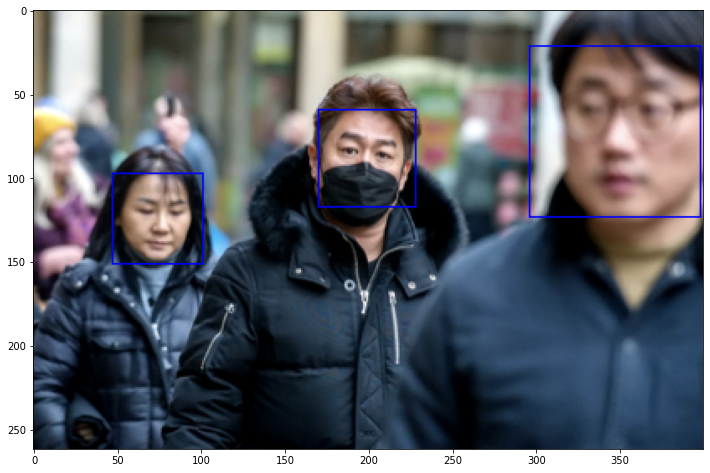

In [22]:
#trying it out on a sample image
img_test = cv2.imread('/content/MaskImageDataSet/maksssksksss244.png')

#Set Grayscale into image
img_test = cv2.cvtColor(img_test, cv2.IMREAD_GRAYSCALE)
#Detect face from sample image
faces_test = face_model.detectMultiScale(img_test,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples 
#Convert grayscale to normal color
out_img_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2BGR) #colored output image

#plotting sample image
for (x,y,w,h) in faces_test:
    cv2.rectangle(out_img_test,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img_test)

**3. model**

Define VGG19 model

VGG19 is convolution neural network. The weight of network use database from imagenet that trained from 1 million image 224x224 pixels with 3 dimensions. (R G B)

In [23]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())

# output 2 layers (2 class)
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


**Complie VGG19 model**

In [24]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

**Fit VGG19 model**

In [25]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator)//32, epochs=5,
                    validation_data=val_generator, validation_steps=len(val_generator)//32)

Epoch 1/5
9/9 [==============================] - 2s 190ms/step - loss: 0.5533 - accuracy: 0.7083
Epoch 2/5
9/9 [==============================] - 2s 164ms/step - loss: 0.2726 - accuracy: 0.9028
Epoch 3/5
9/9 [==============================] - 1s 162ms/step - loss: 0.2126 - accuracy: 0.9236
Epoch 4/5
9/9 [==============================] - 2s 166ms/step - loss: 0.1494 - accuracy: 0.9479
Epoch 5/5
9/9 [==============================] - 1s 161ms/step - loss: 0.1496 - accuracy: 0.9410


**4.Evaluate model**

In [26]:
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

31/31 [==============================] - 5s 158ms/step - loss: 0.1535 - accuracy: 0.9375
evaluate accuracy: 93.75%


Testing VGG19 model on the test data

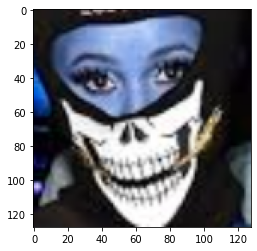

In [27]:
sample_mask_img = cv2.imread('/content/MaskImageDataSet/Face Mask Dataset12K/Test/WithMask/178.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

The model is able to classify if the person is wearing a mask or not.

array = [wearmask_prob not_wearmask_prob]

if wearmask_prob > 0.5: print wearmask

elif not_wearmask_prob > 0.5: print notwearmask

ex [0.8473643 , 0.14077875] ans wearmask

In [28]:
model.predict(sample_mask_img)

1/1 [==============================] - 0s 146ms/step


array([[0.4362854, 0.69587  ]], dtype=float32)

Map categorical and RGB code to ordinal number

In [29]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)} #Green, Red

Define minimum distance

In [30]:
MIN_DISTANCE = 130

Processing social distance and face mask

Define mask from image

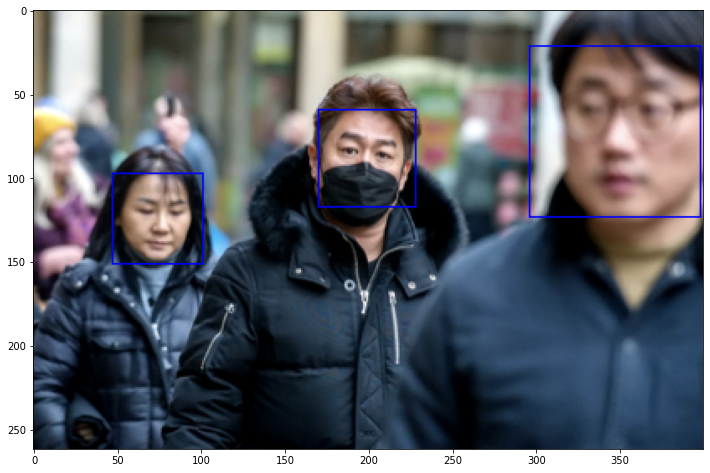

In [31]:
#trying it out on a sample image
img = cv2.imread('/content/MaskImageDataSet/maksssksksss244.png')
height, width, channels = img.shape
thickness = 1

#if width >= 500 set rectangle thickness = 2 
if (width >= 500):
    thickness = 2

#Set Grayscale into image
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

#Detect face from sample image
#returns a list of (x,y,w,h) tuples 
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

#Convert grayscale to normal color
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting sample image
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),thickness)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

Execute function

1/1 [==============================] - 0s 15ms/step


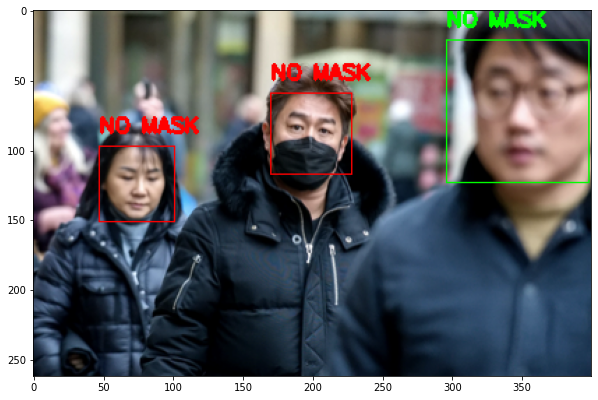

In [32]:
if len(faces)>=2:
    # from sample image len(faces) = 3
    # set initial label array [0, 0, 0]
    label = [0 for i in range(len(faces))] # 0, 1, 2
    for i in range(len(faces)-1): # 0 in 2
        for j in range(i+1, len(faces)): # i+1 in 3
            # faces = x, y , w ,h = [x y w h] #faces[i][:2] = [x y]
            # dist_euclid = root((x1-x2)^2+(y1-y2)^2)
            dist = distance.euclidean(faces[i][:2],faces[j][:2]) 
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    #if width >= 500 set rectangle thickness = 2            
    thickness = 1
    if (width >= 500):
      thickness = 2
    
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image (convert grayscale to normal scale)
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0

        # Predict crop image mask label and set distance rectangle
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],thickness)
    # Show image    
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    #if width >= 500 set rectangle thickness = 2            
    thickness = 1
    if (width >= 500):
      thickness = 2
    
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image (convert grayscale to normal scale)
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0

        # Predict crop image mask label and set distance rectangle
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,0,255),thickness)
    # Show image    
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)